# Reducing Traffic Mortality 

### includes

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

### The raw data files and their format

In [175]:
Miles_Driven_Path=r"D:\Reducing Traffic Mortality\miles-driven.csv"
Road_Accidents_Path=r"D:\Reducing Traffic Mortality\road-accidents.csv"

### Read in and get an overview of the data

In [176]:
Miles_Driven_Data=pd.read_csv(Miles_Driven_Path,sep="|",index_col='state')
Miles_Driven_Data.head()


,million_miles_annually
state,
Alabama,64914
Alaska,4593
Arizona,59575
Arkansas,32953
California,320784


In [177]:
Road_Accidents_Data=pd.read_csv(Road_Accidents_Path,sep="|",skiprows = 9,index_col='state')
Road_Accidents_Data.head()

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
state,,,,
Alabama,18.8,39,30,80
Alaska,18.1,41,25,94
Arizona,18.6,35,28,96
Arkansas,22.4,18,26,95
California,12.0,35,28,89




### drvr_fatl_col_bmiles = Number of drivers involved in fatal collisions per billion miles (2011)

### perc_fatl_speed = Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding (2009)

### perc_fatl_alcohol = Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired (2011)

### perc_fatl_1st_time = Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents (2011)



### Create a textual and a graphical summary of the data


In [178]:
Miles_Driven_Data.describe()

,million_miles_annually
count,51.000000
mean,57851.019608
std,59898.414088
min,3568.000000
25%,17450.000000
50%,46606.000000
75%,71922.500000
max,320784.000000


In [179]:
Road_Accidents_Data.describe()

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
count,51.000000,51.000000,51.000000,51.00000
mean,15.790196,31.725490,30.686275,88.72549
std,4.122002,9.633438,5.132213,6.96011
min,5.900000,13.000000,16.000000,76.00000
25%,12.750000,23.000000,28.000000,83.50000
50%,15.600000,34.000000,30.000000,88.00000
75%,18.500000,38.000000,33.000000,95.00000
max,23.900000,54.000000,44.000000,100.00000


In [180]:
Data=Miles_Driven_Data.join(Road_Accidents_Data)
Data.head()

,million_miles_annually,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
state,,,,,
Alabama,64914,18.8,39,30,80
Alaska,4593,18.1,41,25,94
Arizona,59575,18.6,35,28,96
Arkansas,32953,22.4,18,26,95
California,320784,12.0,35,28,89


In [181]:
Data = Data.rename(columns=dict(million_miles_annually='billion_miles_annually'))
temp=Data['billion_miles_annually']/1000
Data['billion_miles_annually'] =temp

Data.head()


,billion_miles_annually,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
state,,,,,
Alabama,64.914,18.8,39,30,80
Alaska,4.593,18.1,41,25,94
Arizona,59.575,18.6,35,28,96
Arkansas,32.953,22.4,18,26,95
California,320.784,12.0,35,28,89


In [182]:
Data['drvr_fatl_col'] =Data['billion_miles_annually']*Data['drvr_fatl_col_bmiles']
Data['fatl_speed'] =Data['perc_fatl_speed']*Data['drvr_fatl_col']/100
Data['fatl_alcohol'] =Data['perc_fatl_alcohol']*Data['drvr_fatl_col']/100
Data['fatl_1st_time'] =Data['perc_fatl_1st_time']*Data['drvr_fatl_col']/100


Data = Data.drop('billion_miles_annually', axis=1)
Data = Data.drop('drvr_fatl_col_bmiles', axis=1)
Data = Data.drop('perc_fatl_speed', axis=1)
Data = Data.drop('perc_fatl_alcohol', axis=1)
Data = Data.drop('perc_fatl_1st_time', axis=1)

Data.head()

,drvr_fatl_col,fatl_speed,fatl_alcohol,fatl_1st_time
state,,,,
Alabama,1220.3832,475.949448,366.114960,976.306560
Alaska,83.1333,34.084653,20.783325,78.145302
Arizona,1108.0950,387.833250,310.266600,1063.771200
Arkansas,738.1472,132.866496,191.918272,701.239840
California,3849.4080,1347.292800,1077.834240,3425.973120


In [183]:
Data_scaled= Data.copy()
for column in Data:
    Data_scaled[column] = Data_scaled[column]  / Data_scaled[column].abs().max()


<AxesSubplot:xlabel='state', ylabel='drvr_fatl_col'>

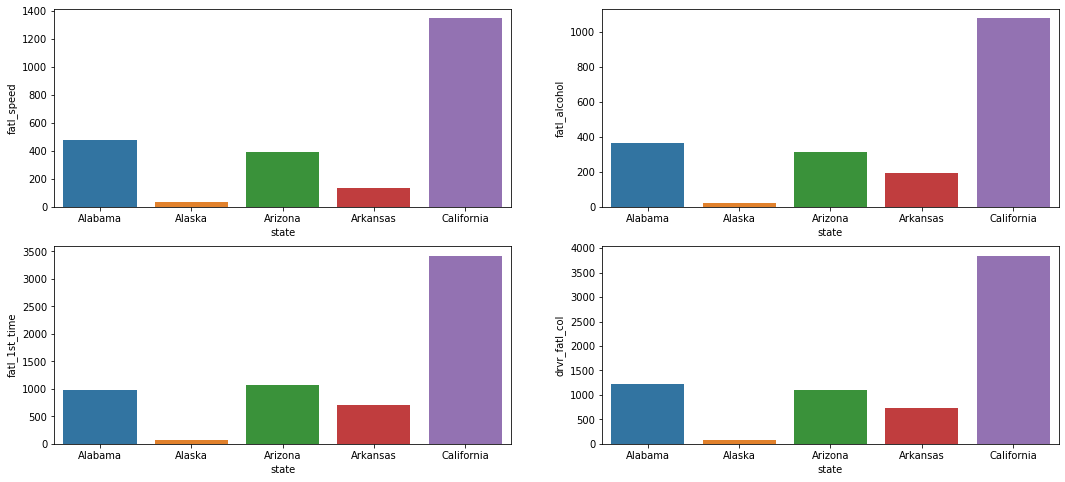

In [184]:
data_head=Data.head()
plt.figure(figsize=(18,8))
plt.subplot(2, 2, 1)
sns.barplot(x=data_head.index,y=data_head["fatl_speed"])
plt.subplot(2, 2, 2)
sns.barplot(x=data_head.index,y=data_head["fatl_alcohol"])
plt.subplot(2, 2, 3)
sns.barplot(x=data_head.index,y=data_head["fatl_1st_time"])
plt.subplot(2, 2, 4)
sns.barplot(x=data_head.index,y=data_head["drvr_fatl_col"])




<AxesSubplot:xlabel='fatl_speed', ylabel='fatl_alcohol'>

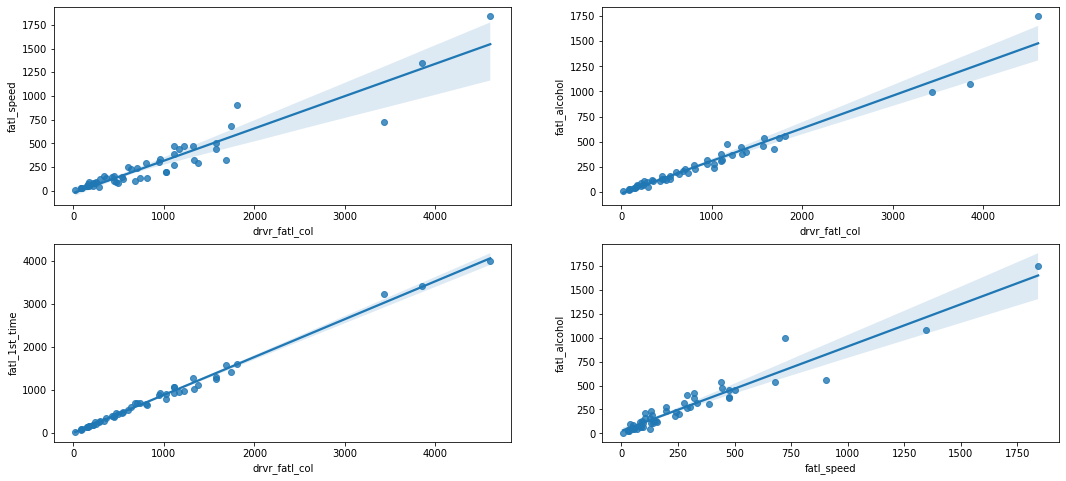

In [185]:
plt.figure(figsize=(18,8))
plt.subplot(2, 2, 1)
sns.regplot(x=Data["drvr_fatl_col"],y=Data["fatl_speed"])
plt.subplot(2, 2, 2)
sns.regplot(x=Data["drvr_fatl_col"],y=Data["fatl_alcohol"])
plt.subplot(2, 2, 3)
sns.regplot(x=Data["drvr_fatl_col"],y=Data["fatl_1st_time"])
plt.subplot(2, 2, 4)
sns.regplot(x=Data["fatl_speed"],y=Data["fatl_alcohol"])


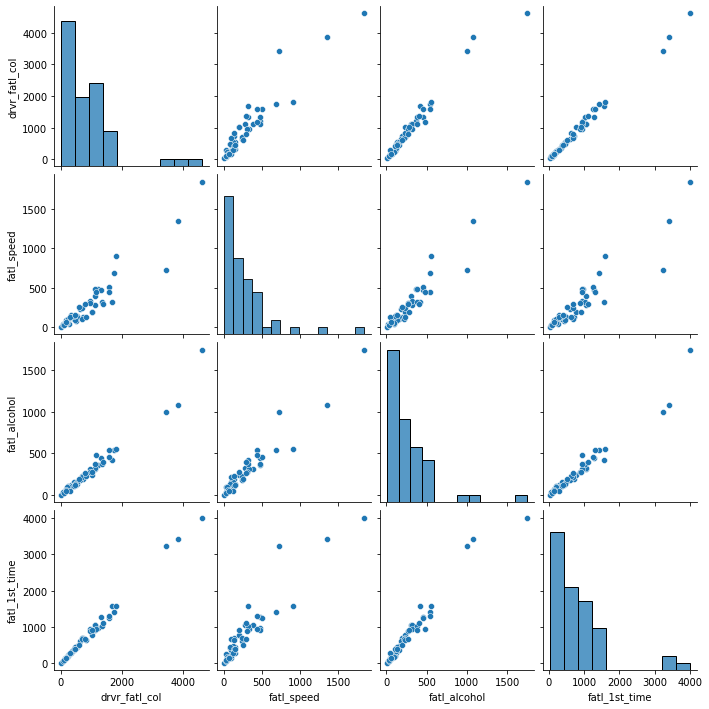

In [186]:
sns.pairplot(Data)


### Quantify the association of features and accidents

In [187]:
Data.corr()

,drvr_fatl_col,fatl_speed,fatl_alcohol,fatl_1st_time
drvr_fatl_col,1.000000,0.942785,0.982053,0.996625
fatl_speed,0.942785,1.000000,0.962503,0.932976
fatl_alcohol,0.982053,0.962503,1.000000,0.975681
fatl_1st_time,0.996625,0.932976,0.975681,1.000000


<AxesSubplot:>

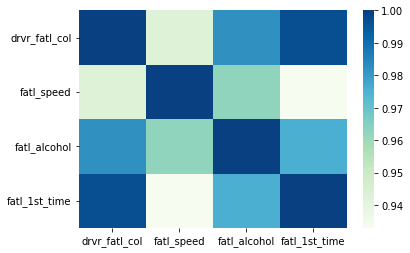

In [188]:
sns.heatmap(Data.corr() ,cmap=plt.cm.GnBu)

### Fit a multivariate linear regression

In [189]:
# with sklearn
regr = linear_model.LinearRegression()
x=Data[['fatl_speed','fatl_alcohol','fatl_1st_time']]
y=Data['drvr_fatl_col']
regr.fit(x, y)

#print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

Coefficients: 
 [0.09331756 0.4981264  0.9088857 ]
                            OLS Regression Results                            
Dep. Variable:          drvr_fatl_col   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     3309.
Date:                Sat, 06 Aug 2022   Prob (F-statistic):           1.16e-54
Time:                        19:31:25   Log-Likelihood:                -283.70
No. Observations:                  51   AIC:                             575.4
Df Residuals:                      47   BIC:                             583.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

### Perform PCA on standardized data

In [190]:
Data_std = Data.copy()
for column in Data_std.columns:
    Data_std[column] = (Data_std[column] - Data_std[column].mean()) / Data_std[column].std()

x=Data_std[['fatl_speed','fatl_alcohol','fatl_1st_time']]
pca = PCA(n_components=2)
pca.fit(x)
X_PCA_2=pca.transform(x)

### Visualize the first two principal components

Text(0.5, 1.0, 'variance ratio=99.0')

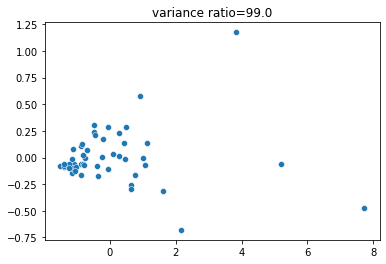

In [191]:
sum(pca.explained_variance_ratio_*100)
sns.scatterplot(x=X_PCA_2[:,0],y=X_PCA_2[:,1])
plt.title('variance ratio='+str(sum(pca.explained_variance_ratio_*100).round()))

### Find clusters of similar states in the data

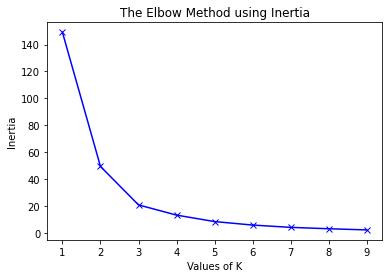

In [192]:
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_PCA_2)

    inertias.append(kmeanModel.inertia_)

    
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

### KMeans to visualize clusters in the PCA scatter plot

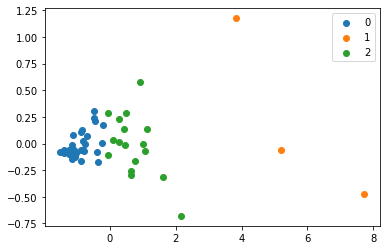

In [193]:
kmeanModel = KMeans(n_clusters=3)
label = kmeanModel.fit_predict(X_PCA_2)
 
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(X_PCA_2[label == i , 0] , X_PCA_2[label == i , 1] , label = i)
plt.legend()
plt.show()


### Visualize the feature differences between the clusters

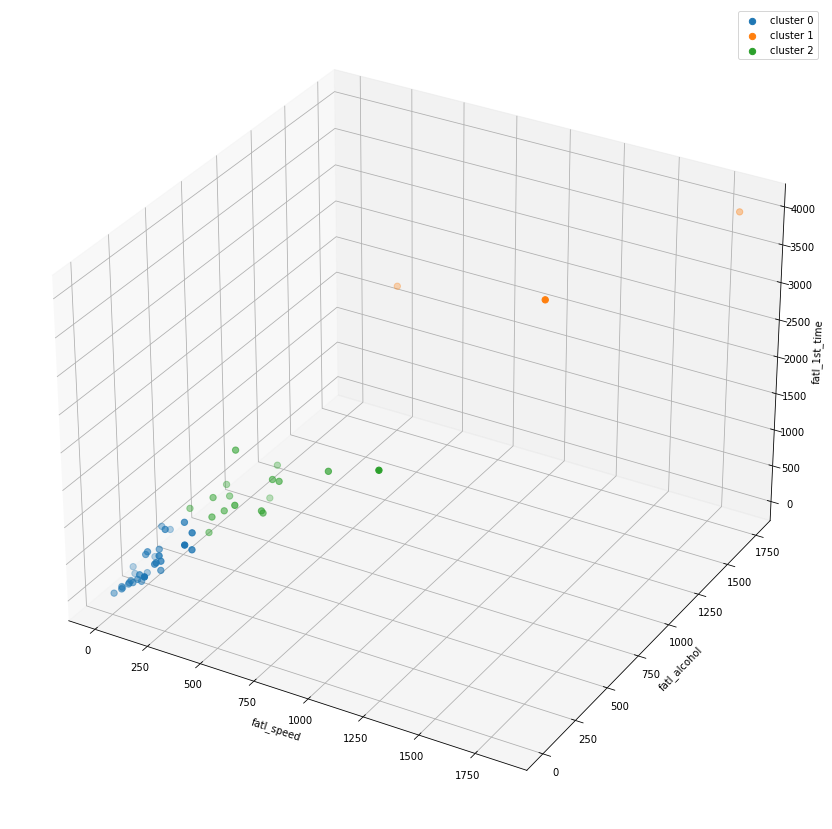

In [194]:
x=np.array(Data[['fatl_speed','fatl_alcohol','fatl_1st_time']])
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
for i in u_labels:
    ax.scatter(x[label == i,0],x[label == i,1],x[label == i,2], s = 40 , label = "cluster "+str(i))

ax.set_xlabel('fatl_speed')
ax.set_ylabel('fatl_alcohol')
ax.set_zlabel('fatl_1st_time')
ax.legend()
plt.show()

### Compute the number of accidents within each cluster

In [195]:
Data['cluster_num']=label    
Accidents_per_Cluster=Data.groupby(['cluster_num'])['drvr_fatl_col'].agg(['count', 'sum'])
Accidents_per_Cluster

,count,sum
cluster_num,,
0,31,11873.2115
1,3,11889.9485
2,17,21872.0504


<AxesSubplot:xlabel='cluster_num', ylabel='drvr_fatl_col'>

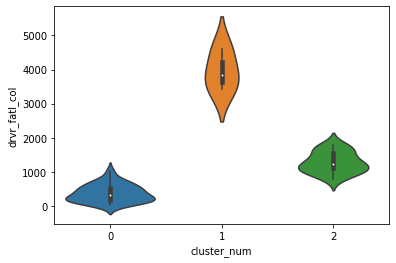

In [196]:
sns.violinplot(x=Data["cluster_num"],y=Data['drvr_fatl_col'])

### well cluster 0 contains 31 states and a total number of accidents of 11652 this can tell us that number of accidents per state is low compared with clusters 1 and 2

### cluster 1 has the highest accident per state ratio so police should focus on cluster 1

### cluster 2 has a relatively high accident per state ratio but the highest number of accidents so maybe the police should focus on cluster 2 as it serves more states and probably reduces the number of accidents significantly 